# Computation of virtual orbitals and check of the completeness relation for $N_2$

We compute the virtual orbitals of the $N_2$ molecule and evalute the maximum energy sampled by the system. Then we use this basis to express the occupied orbitals of the same molecule subjected to a static electric field.

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import json
import sys
sys.path.insert(0,'../../')
import Routine as R
outputpath = 'virtual-orbitals/'

Autosave disabled


First of all we define the python dictionary that contains the basic keys common to all the file in the run and we write these common variables in the default file

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.40,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

## Computation of the virtual orbitals (cubic code)

The aim of this computation is to produce the set of virtual orbitals, up to the highest value specified by the 'virtMax' parameter with a maximum residue of $1e^{-4}$. To obtain this result we produce a list of virtual orbitals denoted as 'virt' (using a linear spacing). virt contains a number of virtual orbitals higher than virtMax, because the last elements have a higher residue and are included only to improve the convergence of the lower ones.

The computation is performed for rMult = 7.0 and 9.0, but the code is written in a way prone to the inclusion of other values.

In [7]:
rVal = [7.0,9.0,11.0]
virt = {}
virt[7.0] = [16,32,64,128,256,288,304,320]
virt[9.0] = [16,32,64,128,256,288,304,320]
virt[11.0] = [16*i for i in range(1,18)]
virt[11.0].append(284)
print virt

{9.0: [16, 32, 64, 128, 256, 288, 304, 320], 11.0: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 284], 7.0: [16, 32, 64, 128, 256, 288, 304, 320]}


We run the first set of calculation with 'itermax_virt' in the range 20-50. In this way we build a first guess of the virtual orbitals. Further refinement are performed later. We build the input file:

In [46]:
for r in rVal:
    inp={'dft':{
          'rmult': [r, 9.0],
          'itermax_virt' : 30,
          'gnrm_cv_virt' : 1e-4},
         'output': {
          'orbitals' : 'binary',
          'verbosity' : 3}
        }
    inp['radical'] = 'Rmult_'+str(r)
    lrun=[]
    for n in virt[r]:
        inp['dft']['norbv'] = -n
        inpname = 'Rmult_'+str(r)+'_numVirt_'+str(n)
        Yaml.dump(inp,outputpath + inpname + '.yaml')
        lrun.append(inpname)
    Yaml.dump(lrun,outputpath+'runs_'+str(r))

and execute the computation via the run file:

In [47]:
code=C.SystemCalculator(omp=2,mpi=4)

%cd $outputpath
r = 11.0
code.run(run_name='runs_'+str(r),skip=True,outdir='./log/')
#for r in rVal:
#    code.run(run_name='runs_'+str(r),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_11.0 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc


We read the log files associated to the highest number of virtual orbitals and organize them in the lists Data.

In [8]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(virt[r][-1])+'.yaml'
    log = !ls $spath
    print log
    Data.append(lf.Logfile(log[0]))
%cd ..

[Errno 2] No such file or directory: 'virtual-orbitals/'
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/virtual-orbitals
['log/log-Rmult_7.0_numVirt_320.yaml']
['log/log-Rmult_9.0_numVirt_320.yaml']
['log/log-Rmult_11.0_numVirt_284.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc


We extract the value of the residue od the each orbital and plot it (we also display the reference value).

In [9]:
residues = []
for d in Data:
    residues.append(d.log['Optimization of virtual orbitals'][-2]['Residues per orbital'])

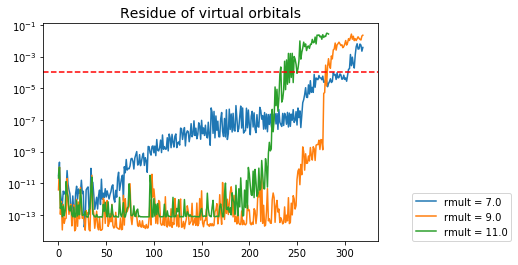

In [10]:
for r in range(len(rVal)):
    plt.plot(residues[r],label='rmult = '+str(rVal[r]))
plt.axhline(y=1e-4, color='r', linestyle='--')
plt.title('Residue of virtual orbitals',fontsize=14)
plt.yscale('log')
plt.legend(loc=(1.1,0.0))
plt.show()

On the basis of this plot we set the number of virtual orbitals with the chosen level of confidence

In [11]:
virtMax = []
errMax = 1e-4
for r in residues:
    notExcede = True
    i = 0
    while (notExcede):
        if r[i] > errMax:
            notExcede = False
        i+=1

    virtMax.append(i-2)
print 'virtMax = ', virtMax

virtMax =  [303, 279, 232]


To refine the result we perform the computation again (with a higher value of 'itermax_virt') and if needed we repeat the computation starting from the number of virtual orbitals that exceed the maximum allowed value:

In [25]:
r = 2
print 'Rmult = ', rVal[r]
virt_reduced = [284,272,284]
print virt_reduced

Rmult =  11.0
[284, 272, 284]


In [26]:
inp={'dft':{
        'rmult': [rVal[r], 9.0],
        'itermax_virt' : 50,
        'gnrm_cv_virt' : 1e-4},
     'output': {
        'orbitals' : 'binary',
        'verbosity' : 3}
     }
inp['radical'] = 'Rmult_'+str(rVal[r])
lrun=[]
for n in virt_reduced:
    inp['dft']['norbv'] = -n
    inpname = 'Rmult_'+str(rVal[r])+'_numVirt_'+str(n)
    Yaml.dump(inp,outputpath + inpname + '.yaml')
    lrun.append(inpname)
Yaml.dump(lrun,outputpath+'runs_reduced_'+str(rVal[r]))

we execute againg the selected input files

In [10]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
code.run(run_name='runs_reduced_'+str(rVal[r]),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_reduced_11.0 -d ./log/
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc


We proceed with the refinement up to the choosen level of precision.

We observe that the last computation performed is the one with the highest number of virtual orbitals, so the orbitals written on file are associated to this log, and we have to refer to it in order to correctly attribute energy and other paramters associated to them.

## Scaling of the energy vs. number of virtual orbitals

We read data in the log associated to a specific number of virtual orbitals

In [12]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(virt[r][-1])+'.yaml'
    log = !ls $spath
    print log
    Data.append(lf.Logfile(log[0]))
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc/virtual-orbitals
['log/log-Rmult_7.0_numVirt_320.yaml']
['log/log-Rmult_9.0_numVirt_320.yaml']
['log/log-Rmult_11.0_numVirt_284.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/free-bc


We build the array with the energy of the empty orbitals, up to virtMax. Results are expressed in eV

In [13]:
numOccOrb = 5
engVirt = []
for r in range(len(rVal)):
    print 'Rmult = ', rVal[r], 'virtMax = ', virtMax[r]
    eVirt = 27.211*Data[r].evals[0][0][numOccOrb:numOccOrb+virtMax[r]]
    engVirt.append([e for e in eVirt])

Rmult =  7.0 virtMax =  303
Rmult =  9.0 virtMax =  279
Rmult =  11.0 virtMax =  232


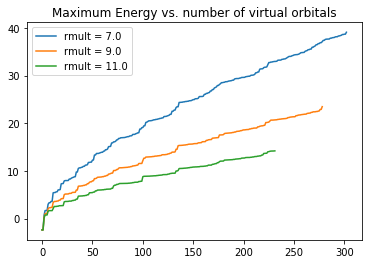

In [14]:
for r in range(len(rVal)):
    plt.plot(engVirt[r],label='rmult = '+str(rVal[r]))
plt.title('Maximum Energy vs. number of virtual orbitals',fontsize=12)
plt.legend()
plt.show()

In [16]:
# write engVirt for rmult = 7.0 on file
%cd $outputpath
f = open('engVirt.txt','w')
json.dump(engVirt[0],f)
f.close()
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We also plot the difference of the energy between two adiacent virtual orbitals:

In [22]:
r = 2
print 'Rmult = ', rVal[r]
deltaEng = []
for i in range(len(engVirt[r])-1):
    deltaEng.append(engVirt[r][i+1]-engVirt[r][i])

Rmult =  11.0


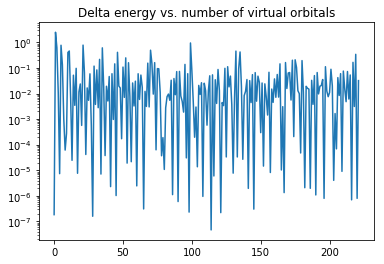

In [23]:
plt.plot(deltaEng)
plt.title('Delta energy vs. number of virtual orbitals',fontsize=12)
plt.yscale('log')
plt.show()

## Expansion of the perturbed KS orbitals (cubic code)

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e^{-2}$ both in the $z$ and $x$ directions. First of all we we build the input file, perform the computations and read the results.

### Generation of the input files and execution of the computations

In [19]:
for i,r in enumerate(rVal):
    psip_Ex = '../static-field/log/data-Ex_1em2_rmult_'+str(r) #relative path starting from outputpath
    psip_Ez = '../static-field/log/data-Ez_1em2_rmult_'+str(r)
    inpEx={'dft':
           {'rmult': [r, 9.0],
            'norbv': -virtMax[i],
            'itermax_virt' : 1},
           'output': {'orbitals' : 'No'},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ex}}
    inpEz={'dft':
           {'rmult': [r, 9.0],
            'norbv': -virtMax[i],
            'itermax_virt' : 1},
           'output': {'orbitals' : 'No'},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ez}}
    InpnameEx = 'CR_Ex_rmult_'+str(r)+'_numVirt_'+str(virtMax[i])
    InpnameEz = 'CR_Ez_rmult_'+str(r)+'_numVirt_'+str(virtMax[i])

    Yaml.dump(inpEz,outputpath + InpnameEz + '.yaml')
    Yaml.dump(inpEx,outputpath + InpnameEx + '.yaml')
    # execute the input files
    %cd $outputpath
    code.run(name=InpnameEx,skip=True,outdir='./log/')
    code.run(name=InpnameEz,skip=True,outdir='./log/')
    %cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_7.0_numVirt_303 -d ./log/ -s Yes
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_7.0_numVirt_303 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_9.0_numVirt_279 -d ./log/ -s Yes
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_9.0_numVirt_279 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [20]:
# read the data. First index for the value of rmult, second index for the direction of the field
CR_data = []
%cd $outputpath
for i,r in enumerate(rVal):
    spath = 'log/log-CR_E*_rmult_'+str(r)+'_numVirt_'+str(virtMax[i])+'.yaml'
    logs = !ls $spath
    print logs
    CR_data.append([lf.Logfile(l) for l in logs])
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
['log/log-CR_Ex_rmult_7.0_numVirt_303.yaml', 'log/log-CR_Ez_rmult_7.0_numVirt_303.yaml']
['log/log-CR_Ex_rmult_9.0_numVirt_279.yaml', 'log/log-CR_Ez_rmult_9.0_numVirt_279.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

### Assessment of the completeness of the basis

The natural normalization condition for the (perturbed) occupied orbitals and the fact that orbitals can be chosen to be real functions, imply the following condition:
$$
n_{occ} = \sum_p \langle\psi'_p|\psi'_p\rangle =
\sum_p \int dr \psi'_p(r)^2
$$
We expand the perturbed orbitals on the basis of the unpertubed ones (occupied and empty). If the basis is complete we have the following equality:
$$
\psi'_p(r) = \sum_p a_{pq}\psi_p(r) + \sum_{\alpha}a_{p\alpha}\psi_{\alpha}(r)
$$
Plugging this expansion in the first formula and remembering that the eigenstates of $H_0$ are orthonormal we have:
$$
n_{occ} = \sum_{pq}a_{pq}^2 + \sum_{p\alpha}a_{p\alpha}^2
$$
This equation can be used as an estimator to assess the completeness of a basis (built in terms of a finite number of empty orbitals). We observe that the contribute of the empty orbitals has to be equal to:
$$
R = n_{occ} - \sum_{pq}a_{pq}^2 
$$
and we can intrdoduce the following estimator
$$
S_{n_{virt}} = R - \sum_{p}\sum_{\alpha=1}^{n_{virt}}a_{p\alpha}^2
$$
$S_{n_{virt}}$ is positive definite and vanishes only id the basis is complete. We observe that $S_{n_{virt}}$ is an extensive quantity (it scales linearly with the number of electrons), so in order to define an estimator that is independent from the size of the system we can analyze the quantity $S_{n_{virt}}/n_{occ}$. 

If we want to analyze the influence of the basis orbital per orbital we can introduce the partial estimators
$$
S^{p}_{n_{virt}} = 1 - \sum_{q}a_{pq}^2  - \sum_{\alpha=1}^{n_{virt}}a_{p\alpha}^2 \doteq R^{p} 
- \sum_{\alpha=1}^{n_{virt}}a_{p\alpha}^2 
$$
$S^{p}_{n_{virt}}$ is linked to the global estimator by the relation:
$$
\sum_{p}S^{p}_{n_{virt}} = S_{n_{virt}}
$$
The routine that perform this computation is defined in the Routine.py module. The function evalS_nirt computes the "intensive" estimator $S_{n_{virt}}/n_{occ}$.

In [30]:
reload(R)
r = 0
print 'Rmult = ', rVal[r]
S_nvirt_Ex = R.evalS_nvirt(CR_data[r][0])
S_nvirt_Ez = R.evalS_nvirt(CR_data[r][1])

Rmult =  7.0
no_occ 5 n_vrt 303
R =  0.000371753750386
no_occ 5 n_vrt 303
R =  0.000533261680008


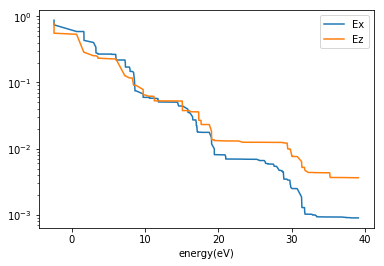

In [31]:
plt.semilogy(engVirt[r],S_nvirt_Ex,label='Ex')
plt.semilogy(engVirt[r],S_nvirt_Ez,label='Ez')
plt.xlabel('energy(eV)')
plt.legend()
plt.show()

It is also interesting to compare the shape of the curves when plotted in terms of the number of virtual orbitals:

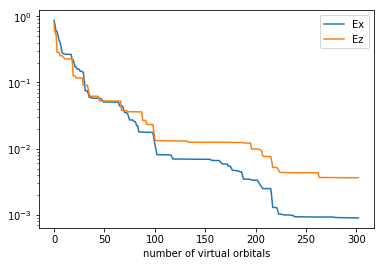

In [51]:
plt.semilogy(S_nvirt_Ex,label='Ex')
plt.semilogy(S_nvirt_Ez,label='Ez')
plt.xlabel('number of virtual orbitals')
plt.legend()
plt.show()

In [21]:
# write S_nvirt_Ex and S_nvirt_Ez on file (for rmult = 7.0)
r = 0
S_nvirt_Ex = R.evalS_nvirt(CR_data[r][0])
S_nvirt_Ez = R.evalS_nvirt(CR_data[r][1])
%cd $outputpath
f = open('S_nvirt_Ex.txt','w')
json.dump(S_nvirt_Ex,f)
f.close()
f = open('S_nvirt_Ez.txt','w')
json.dump(S_nvirt_Ez,f)
f.close()
%cd ../

no_occ 5 n_vrt 303
R =  0.000371753750386
no_occ 5 n_vrt 303
R =  0.000533261680008
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


### A different assessment of the completeness of the basis

We consider a generic observable $O$ and remember the formal definition of $Q_0$, the projection operator on the subspace orthogonal to $\rho_0$:
$$
Q_0 = 1 - \rho_0
$$
We can write the following operatorial equality:
$$
1\cdot O \cdot 1 = (Q_0+\rho_0)O(Q_0+\rho_0) = \bar O + \tilde O
$$
where
$$
\bar O = \rho_0 O \rho_0 + Q_0 O Q_0 \, , \quad
\tilde O = Q_0 O \rho_0 + \rho_0 O Q_0
$$
$\bar O$ is the part of $O$ that commutes with $\rho_0$, while $\tilde O$ does not commute with $\rho_0$ and satisfies the properties:
$$
tr(\tilde O) = 0
$$

We now consider the expectation value of $O$:
$$
R(O) = tr(O\rho')
$$
In the framework of linear response $\rho'$ is written as the commutator of a proper time evolution operator with 
$\rho'$, so applying the previous decomposition we can substitute $\rho'$ with $\tilde\rho'$. Using the explict expression of $\tilde\rho'$ we have:
$$
R(O) = tr(O\tilde\rho') = tr(OQ_0\rho'\rho_0 + O\rho_0\rho'Q_0) = 
tr(\rho_0 O Q_0\rho' + Q_0 O\rho_0\rho') = tr(\tilde O\rho')
$$
As a final remark, we observe that $\rho'=\rho-\rho_0$ and the trace of $\tilde O$ with $\rho_0$ vanishes due to the presence of $Q_0$ in the definition of $\tilde O$. So we can write:
$$
R(O) = tr(\tilde O \rho)
$$

We use this equation to perform an assessment of the completeness of the transition basis. We consider the dipole operator and perform a (statical) computation with the BigDFT code, using the explicit electric field, to build the reference result. So, according to the previous equations we have:
$$
<d> = tr(\rho_0 d Q_0 \rho) + tr(Q_0 d \rho_0 \rho)
$$
We choose a basis considering both occupied and empty orbitals, as usual. If this basis is complete the completeness relation is satisfied:
$$
1 = \sum_p |\psi_p><\psi_p| + \sum_{\alpha}|\psi_\alpha><\psi_\alpha|
$$
This relation implies that:
$$
\rho_0 = \sum_p |\psi_p><\psi_p| \;, \quad Q_0 = \sum_{\alpha}|\psi_\alpha><\psi_\alpha|
$$
furthemore we have that:
$$
\rho = \sum_p |\psi'_p><\psi'_p|
$$
where the states $|\psi'_p>$ are the occupied orbitals in the system with the explicit electric field. We have that:
$$
tr(\rho_0 d Q_0 \rho) = tr\left(\sum_p|\psi_p><\psi_p|d
\sum_{\alpha}|\psi_\alpha><\psi_\alpha| \sum_q |\psi'_q><\psi'_q| \right) = \\ =
\sum_{pq\alpha}<\psi_p|d|\psi_\alpha><\psi_\alpha|\psi'_q><\psi'_q|\psi_p>
$$
We introduce some other notation:
$$
|\psi'_p> = \sum_q a_{pq}|\psi_q> + \sum_\alpha b_{p\alpha}|\psi_\alpha> \, \rightarrow
a_{pq} = <\psi_q|\psi'_p> \;\; , b_{p\alpha} = <\psi_\alpha|\psi'_p> \\
<\psi_p|d|\psi_\alpha> = d_{p\alpha}
$$
I also observe that, since the states are real:
$$
a_{pq} = <\psi_q|\psi'_p> = <\psi'_p|\psi_q>
$$
so we have:
$$
tr(\rho_0 d Q_0 \rho) = \sum_{pq\alpha} d_{p\alpha} b_{q\alpha}a_{qp} = 
\sum_{pq\alpha} d_{p\alpha} b^{T}_{\alpha q}a_{qp} = tr(d b^{T} a)
$$
We can analyze the second trace in the same way:
$$
tr(Q_0 d \rho_0 \rho) = 
\sum_{pq\alpha}<\psi_\alpha|d|\psi_p><\psi_p|\psi'_q><\psi'_q|\psi_\alpha> = \\
= \sum_{pq\alpha} d_{p\alpha}a_{pq}b_{q\alpha}
= \sum_{pq\alpha} d_{p\alpha}b^{T}_{\alpha q}a^T_{pq} = tr(db^{T}a^{T})
$$